<a href="https://colab.research.google.com/github/sahil-bhatia-iitbhu/deep_understanding_of_deep_learning/blob/main/04_overfitting_and_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Over Fitting and Cross Validation

### Overfitting

1. Overview
2. Techniques to control overfitting
3. Researcher Overfitting
    
    a. Also called researchers degree of freedom.

    b. The researcher has many choices for how to clean, organize, and select the data; and which models and how many models to run.

    Hence, as soon a data clean strategy and model architecture fits better than other iterations, the researcher prefers that model but that doesn't always mean that its the best model.

4. Avoid Researcher Overfitting

    a. Decide the architecture in advance, and make only minor adjustments. (Feasible for frequently-studied problems)

    b. Build a series of models but never use the test set until all models are trained (kaggle-like competition and best of new problems or new models)

### Cross-Validation

1. Overview
2. K-fold Cross validation
3. Assumption of cross-validation:

    The hold-out and test sets are independent of (uncorrelated with) the training set. If this assumption is violated, the relevance of this process is lost, and overfitting persists.

4. Conclusion:
    
    Overfitting is not intrinsically bad, overfitting reduces generizability, which may or may not be problematic depending on the goals and scope of the model.

### Regularization

1. Generalization:
    
    How well the model works well, when applied on new data.

2. Generalization Boundaries:

    The population you want the model to apply to. This concept is really important as you can't apply every model on every scenario, you need to define the boundaries of your model itself.

Hence, you could say that both over-fitting and regularization are relative to each other. The tighter the regularization boundaries, the more research overfitting you might need in regards to the data pertaining within boundaries.

Though, training overfitting should ideally be in control.

### Cross-validation : Manually

In [ ]:
# import libraries
import torch
import torch.nn as nn
import numpy as np


# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')


# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='setosa'] = 0
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

In [ ]:
#  (no devset here)

# how many training examples
propTraining = .8 # in proportion, not percent
nTraining = int(len(labels)*propTraining)
# nTraining = 120

# initialize a boolean vector to select data and labels
traintestBool = np.zeros(len(labels),dtype=bool)
# traintestBool = dataset with all FALSE

# is this the correct way to select samples?
# traintestBool[range(nTraining)] = True

# this is better, but why?
items2use4train = np.random.choice(range(len(labels)),nTraining,replace=False)
# items2use4train = random choice of index to use for training

traintestBool[items2use4train] = True

traintestBool

array([ True, False, False, False, False,  True,  True,  True, False,
        True,  True,  True,  True, False,  True,  True, False,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True, False,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True, False,  True,
       False,  True,

In [ ]:
# test whether it's balanced
print('Average of full data:')
print( torch.mean(labels.float()) ) # =1 by definition
print(' ')

print('Average of training data:')
print( torch.mean(labels[traintestBool].float()) ) # should be 1...
print(' ')

print('Average of test data:')
print( torch.mean(labels[~traintestBool].float()) ) # should also be 1...

Average of full data:
tensor(1.)
 
Average of training data:
tensor(1.)
 
Average of test data:
tensor(1.)


In [ ]:
# create the ANN model

# model architecture
ANNiris = nn.Sequential(
    nn.Linear(4,64),   # input layer
    nn.ReLU(),         # activation unit
    nn.Linear(64,64),  # hidden layer
    nn.ReLU(),         # activation unit
    nn.Linear(64,3),   # output units
      )

# loss function
lossfun = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.01)

In [ ]:
# entire dataset
print( data.shape )

# training set
print( data[traintestBool,:].shape )

# test set
print( data[~traintestBool,:].shape )

torch.Size([150, 4])
torch.Size([120, 4])
torch.Size([30, 4])


In [ ]:

# train the model

numepochs = 1000

# initialize losses
losses = torch.zeros(numepochs)
ongoingAcc = []

# loop over epochs
for epochi in range(numepochs):

  # forward pass
  yHat = ANNiris(data[traintestBool,:])

  # compute accuracy (note: denser than previous code!)
  ongoingAcc.append( 100*torch.mean(
              (torch.argmax(yHat,axis=1) == labels[traintestBool]).float()) )

  # compute loss
  loss = lossfun(yHat,labels[traintestBool])
  losses[epochi] = loss

  # backprop
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

In [ ]:
# compute train and test accuracies

# final forward pass USING TRAINING DATA
predictions = ANNiris(data[traintestBool,:])
trainacc = 100*torch.mean((torch.argmax(predictions,axis=1) == labels[traintestBool]).float())


# final forward pass USING TEST DATA!
predictions = ANNiris(data[~traintestBool,:])
testacc = 100*torch.mean((torch.argmax(predictions,axis=1) == labels[~traintestBool]).float())

In [ ]:
# report accuracies

print('Final TRAIN accuracy: %g%%' %trainacc)
print('Final TEST accuracy:  %g%%' %testacc)

Final TRAIN accuracy: 98.3333%
Final TEST accuracy:  100%


### Cross-validation using scikitlearn and experiment on share of train vs test data

In [ ]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# NEW!
from sklearn.model_selection import train_test_split


# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

In [ ]:
# create our fake dataset

fakedata = np.tile(np.array([1,2,3,4]),(10,1)) + np.tile(10*np.arange(1,11),(4,1)).T
fakelabels = np.arange(10)>4
print(fakedata), print(' ')
print(fakelabels)

[[ 11  12  13  14]
 [ 21  22  23  24]
 [ 31  32  33  34]
 [ 41  42  43  44]
 [ 51  52  53  54]
 [ 61  62  63  64]
 [ 71  72  73  74]
 [ 81  82  83  84]
 [ 91  92  93  94]
 [101 102 103 104]]
 
[False False False False False  True  True  True  True  True]


In [ ]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = \
                        train_test_split(fakedata, fakelabels, test_size=.2)

# NOTE the third input parameter above.
# This can be specified as test size or training size.
# Be mindful of which parameter is written!



# print out the sizes
print('Training data size: ' + str(train_data.shape))
print('Test data size: ' + str(test_data.shape))
print(' ')

# print out the train/test data
print('Training data: ')
print(train_data)
print(' ')

print('Test data: ')
print(test_data)

Training data size: (8, 4)
Test data size: (2, 4)
 
Training data: 
[[ 71  72  73  74]
 [101 102 103 104]
 [ 11  12  13  14]
 [ 41  42  43  44]
 [ 91  92  93  94]
 [ 21  22  23  24]
 [ 31  32  33  34]
 [ 61  62  63  64]]
 
Test data: 
[[51 52 53 54]
 [81 82 83 84]]


In [ ]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.01)

  return ANNiris,lossfun,optimizer

In [ ]:
# train the model

# global parameter
numepochs = 250

def trainTheModel(trainProp):

  # initialize losses
  losses = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # separate train from test data
  # Note 1: unique split for each epoch!
  # Note 2: here we specify the training size, not the testing size!
  X_train, X_test, y_train, y_test = train_test_split(data,labels, train_size=trainProp)

  # loop over epochs
  for epochi in range(numepochs):

    # forward pass and loss
    yHat = ANNiris(X_train)
    loss = lossfun(yHat,y_train)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # compute training accuracy
    trainAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y_train).float()).item() )

    # test accuracy
    predlabels = torch.argmax( ANNiris(X_test),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y_test).float()).item() )

  # function output
  return trainAcc,testAcc

In [ ]:
# testing the functions

# create a model
ANNiris,lossfun,optimizer = createANewModel()

# train the model
# NOTE: the input is the training proportion, not the test proportion!
trainAcc,testAcc = trainTheModel(.8)

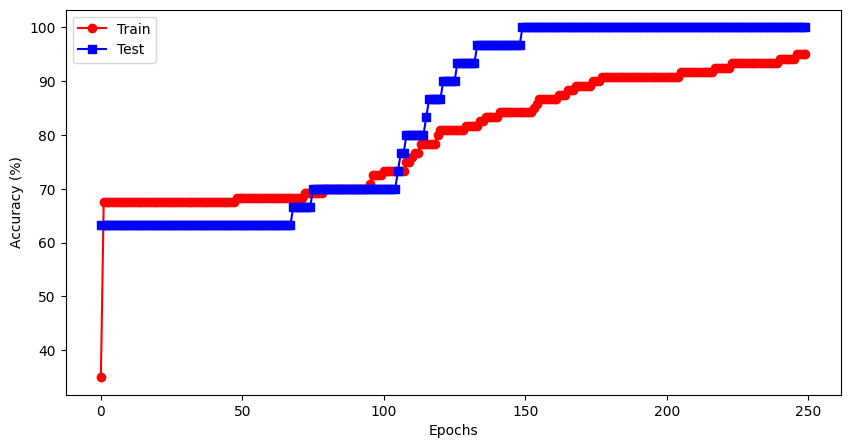

In [ ]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'ro-')
plt.plot(testAcc,'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.show()

In [ ]:
# Now the experiment

trainSetSizes = np.linspace(.2,.95,10)

allTrainAcc = np.zeros((len(trainSetSizes),numepochs))
allTestAcc = np.zeros((len(trainSetSizes),numepochs))

for i in range(len(trainSetSizes)):

  # create a model
  ANNiris,lossfun,optimizer = createANewModel()

  # train the model
  trainAcc,testAcc = trainTheModel(trainSetSizes[i])

  # store the results
  allTrainAcc[i,:] = trainAcc
  allTestAcc[i,:] = testAcc

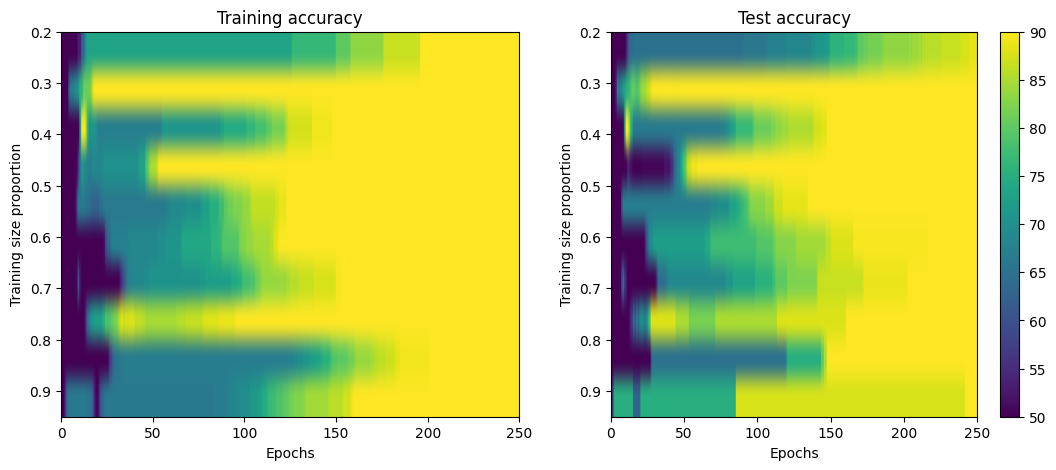

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(13,5))

ax[0].imshow(allTrainAcc,aspect='auto',
             vmin=50,vmax=90, extent=[0,numepochs,trainSetSizes[-1],trainSetSizes[0]])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training size proportion')
ax[0].set_title('Training accuracy')

p = ax[1].imshow(allTestAcc,aspect='auto',
             vmin=50,vmax=90, extent=[0,numepochs,trainSetSizes[-1],trainSetSizes[0]])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training size proportion')
ax[1].set_title('Test accuracy')
fig.colorbar(p,ax=ax[1])

plt.show()

**Conclusion**

No firm result as the dataset is too small, do try this out with a bigger dataset in future.

### PyTorch Dataloaders and Batch Size concept

Using batch to train the model:

  Instead of running backpropagation after every unit of data, instead running it on average of errors of a small bunch of data togethor. This allows stable movements and low variance due to impact of individual entries in data.

In [ ]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# new!
from torch.utils.data import DataLoader, TensorDataset


# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')


# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

In [ ]:
# use scikitlearn to split the dataset
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)

# then convert them into Pytorch datasets
train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
train_loader = DataLoader(train_data,batch_size=5,shuffle=True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0],shuffle=False)

In [ ]:
# let's check through the data
print('TRAINING DATA:')
for batch, label in (train_loader):
  print(batch,label)
  print(' ')

print('TRAINING DATA:')
for batch, label in (test_loader):
  print(batch,label)
  print(' ')

TRAINING DATA:
tensor([[5.7000, 2.6000, 3.5000, 1.0000],
        [5.8000, 2.7000, 5.1000, 1.9000],
        [5.1000, 3.7000, 1.5000, 0.4000],
        [6.1000, 2.9000, 4.7000, 1.4000],
        [5.6000, 2.7000, 4.2000, 1.3000]]) tensor([1, 2, 0, 1, 1])
 
tensor([[6.4000, 3.2000, 4.5000, 1.5000],
        [4.7000, 3.2000, 1.3000, 0.2000],
        [6.1000, 2.6000, 5.6000, 1.4000],
        [5.5000, 2.3000, 4.0000, 1.3000],
        [4.8000, 3.0000, 1.4000, 0.1000]]) tensor([1, 0, 2, 1, 0])
 
tensor([[5.7000, 2.5000, 5.0000, 2.0000],
        [6.5000, 3.0000, 5.8000, 2.2000],
        [7.2000, 3.2000, 6.0000, 1.8000],
        [5.9000, 3.0000, 4.2000, 1.5000],
        [6.3000, 2.8000, 5.1000, 1.5000]]) tensor([2, 2, 2, 1, 2])
 
tensor([[5.0000, 3.0000, 1.6000, 0.2000],
        [7.7000, 3.0000, 6.1000, 2.3000],
        [6.4000, 3.1000, 5.5000, 1.8000],
        [6.2000, 3.4000, 5.4000, 2.3000],
        [4.9000, 3.1000, 1.5000, 0.2000]]) tensor([0, 2, 2, 2, 0])
 
tensor([[6.4000, 2.9000, 4.3000, 1.30

In [ ]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.01)

  return ANNiris,lossfun,optimizer

In [ ]:
# train the model

# global parameter
numepochs = 500

def trainTheModel():

  # initialize accuracies as empties (not storing losses here)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):


    # loop over training data batches
    batchAcc = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item())
    # end of batch loop...


    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append(np.mean(batchAcc))

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

  # function output
  return trainAcc,testAcc

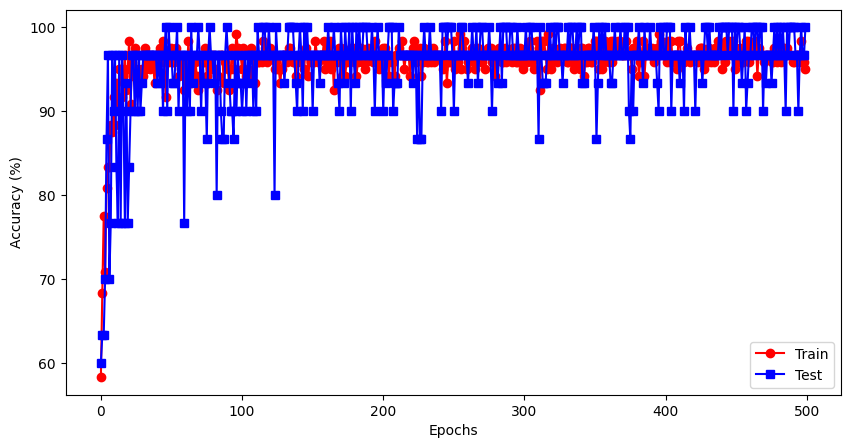

In [ ]:
# create a model
ANNiris,lossfun,optimizer = createANewModel()

# train the model
trainAcc,testAcc = trainTheModel()



# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'ro-')
plt.plot(testAcc,'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])

# optional zoom-in to final epochs
# plt.xlim([300,500])
# plt.ylim([90,100.5])

plt.show()

### Regularization

1. Penalize "memorization"
2. Helps the model generalize to unseen examples
3. Changes the representations of learning (either more sparse or more distributed depending on the regularizer)

**Other observations:**
1. Can increase or decrease training time
2. Can decrease training accuracy but increase generalization
3. Work better for large models with multiple hidden layers
4. Generally works better with sufficient data

**Three families of regularizers**

1. Node Regularization : Modify the model (dropout)
2. Loss Regularization : Add a cost to the loss function (L1/L2)
3. Data Regularization : MOdify or add data (batch training, data augmentation)

**Dropout Regularization**

Dropout reduces the overall activation during training (fewer elements in the weighted sum). This creates an imbalance between the activation units while training vs evaluation/testing.

To resolve the issue there are 2 ways :
1. Scale up the weights during training (Pytorch method)
2. Scale down the weights during testing

**Effects of Dropout:**
1. Prevents the single node from learning too much
2. Forces the model to have distributed representations
3. Makes the model less reliant on individual nodes and thus more stable.

**Other observations:**
- Generally required more training (through eahc epoch computes faster)
- Improves generalization (obviously)
- Works better on deep networks
- Work better with sufficient data, but if data is well structured and sampled then not required.

In [ ]:
# Dropout example

import torch
import torch.nn as nn
import torch.nn.functional as F

# define a dropout instance and make some data
prob = .5

dropout = nn.Dropout(p=prob) # note this is pulled from nn
x = torch.ones(10)

# let's see what dropout returns
y = dropout(x)
print(x)
print(y)#*(1-prob))
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([2., 0., 0., 2., 2., 2., 0., 2., 2., 0.])
tensor(1.2000)


Note:

1. (1-prob) would prove the Pytorch scales up during training
2. Variable average on each hit proves that the probability is not hard bound, but is empirical and is applied on each node where it acts like a switch for each node which has 50% probability of switching on and off.

In [ ]:
# dropout is turned off when evaluating the model
dropout.eval()
y = dropout(x)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


In [ ]:
# annoyingly, F.dropout() is not deactivated in eval mode:

dropout.eval()
y = F.dropout(x)
print(y)
print(torch.mean(y))

# but you can manually switch it off
# dropout.eval()
y = F.dropout(x,training=False)
print(y)
print(torch.mean(y))

tensor([2., 2., 0., 2., 2., 0., 2., 0., 2., 0.])
tensor(1.2000)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


In [ ]:
# the model needs to be reset after toggling into eval mode

dropout.train()
y = dropout(x)
print(y) # with dropout


dropout.eval()
y = dropout(x)
print(y) # without dropout


# dropout.train()
y = dropout(x)
print(y) # still w/o dropout ;)

tensor([2., 2., 2., 2., 2., 2., 2., 0., 0., 0.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


### Dropout Regularization Implementation and Experiment

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Dataset

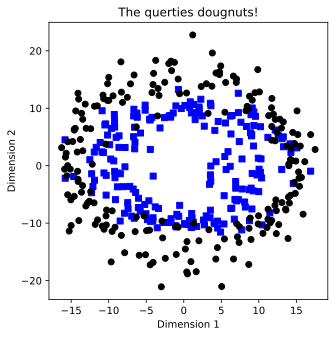

In [7]:
# create the data

nPerClust = 200

th = np.linspace(0,4*np.pi,nPerClust)
r1 = 10
r2 = 15

# generate data
a = [r1*np.cos(th) + np.random.randn(nPerClust)*3,
     r1*np.sin(th) + np.random.randn(nPerClust)]
b = [r2*np.cos(th) + np.random.randn(nPerClust),
     r2*np.sin(th) + np.random.randn(nPerClust)*3]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatenate into matrix
data_np = np.hstack((a,b)).T

# convert the data into tensors
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title("The querties dougnuts!")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [8]:
# separate the data into dataloaders

# use scikitlearn split data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)

# then convert them into pytorch datasets
train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
train_batch_size = 16 #train_data.tensors[0].shape[0]/4
train_loader = DataLoader(train_data,batch_size=5,shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0],shuffle=False)

In [12]:
class theModelClass(nn.Module):
  def __init__(self, dropoutRate):
    super().__init__()

    ### layers
    self.input = nn.Linear(2, 128)
    self.hidden1 = nn.Linear(128, 128)
    self.output = nn.Linear(128, 1)

    # parameters
    self.dr = dropoutRate

  # forward pass
  def forward(self, x):

    # pass the data through input layer
    x = F.relu(self.input(x))

    # dropout
    x = F.dropout(x,p=self.dr,training=self.training)
    # self.training means to turn the dropout ON when model is in training mode and turn OFF when model is in evaluation mode

    # pass the data through hidden layer
    x = F.relu(self.hidden1(x))

    # dropout
    x = F.dropout(x,p=self.dr,training=self.training)

    # pass the data through output layer
    x = self.output(x)

    return x

In [13]:
# test the model
tmpnet = theModelClass(0.25)

# run on some random data
tmpdata = torch.randn(10,2)
y_pred = tmpnet(tmpdata)
y_pred

tensor([[ 0.1050],
        [ 0.0605],
        [ 0.0550],
        [ 0.0189],
        [ 0.2150],
        [ 0.0500],
        [ 0.4880],
        [ 0.0115],
        [-0.0462],
        [ 0.0628]], grad_fn=<AddmmBackward0>)

In [15]:
def createANewModel(dropoutrate):

  # grab an instance of the model class
  ANNQC = theModelClass(dropoutrate)

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNQC.parameters(),lr=.01)

  return ANNQC,lossfun,optimizer

In [19]:
# train the model

# training parameter
numepochs = 500

# NOTE: this time, the model, lossfun, and optimizer are inputs into the function!
def trainTheModel(ANNQC,lossfun,optimizer):

  # initialize accuracies as empties (not storing losses here)
  trainAcc = []
  testAcc  = []


  # loop over epochs
  for epochi in range(numepochs):

    # switch training mode on (is this the right place for this code??)
    ANNQC.train()

    # loop over training data batches
    batchAcc = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNQC(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean(((yHat>0)==y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # test accuracy
    ANNQC.eval() # switch training off
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = ANNQC(X)
    testAcc.append( 100*torch.mean(((yHat>0)==y).float()).item() )

  # function output
  return trainAcc,testAcc

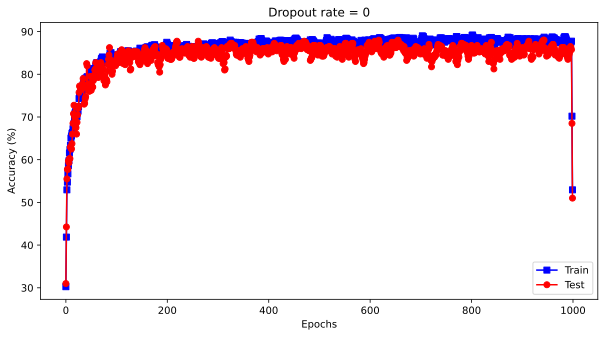

In [17]:
### Test the Model

# create a model
dropoutrate = .0
ANNQC,lossfun,optimizer = createANewModel(dropoutrate)

# train the model (note the inputs!)
trainAcc,testAcc = trainTheModel(ANNQC,lossfun,optimizer)


# create a 1D smoothing filter
def smooth(x,k=5):
  return np.convolve(x,np.ones(k)/k,mode='same')


# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(smooth(trainAcc),'bs-')
plt.plot(smooth(testAcc),'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate = %g'%dropoutrate)

plt.show()

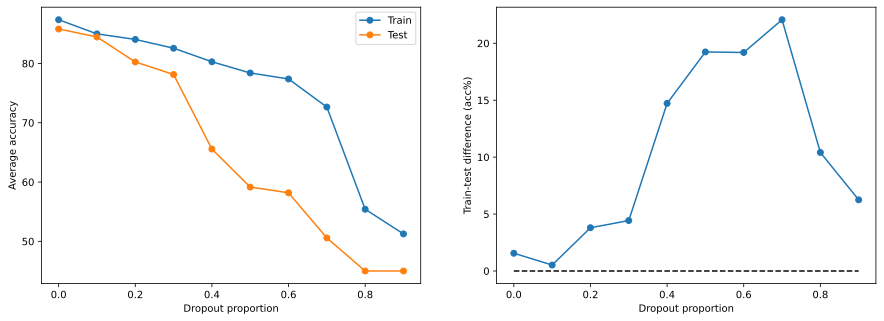

In [20]:
### Now the experiment

dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):

  # create and train the model
  ANNQC,lossfun,optimizer = createANewModel(dropoutRates[di])
  trainAcc,testAcc = trainTheModel(ANNQC,lossfun,optimizer)

  # store accuracies from last 100 epochs
  results[di,0] = np.mean(trainAcc[-100:])
  results[di,1] = np.mean(testAcc[-100:])



# plot the experiment results
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

### Dropout Implementation: Iris Dataset

In [21]:

# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [22]:

# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

In [23]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [24]:
class theModelClass(nn.Module):
  def __init__(self,dropoutRate):
    super().__init__()

    ### layers
    self.input  = nn.Linear( 4,12)
    self.hidden = nn.Linear(12,12)
    self.output = nn.Linear(12, 3)

    # parameters
    self.dr = dropoutRate

  # forward pass
  def forward(self,x):

    # input
    x = F.relu( self.input(x) )
    x = F.dropout(x,p=self.dr,training=self.training) # switch dropout off during .eval()

    # hidden
    x = F.relu( self.hidden(x) )
    x = F.dropout(x,p=self.dr,training=self.training)

    # output
    x = self.output(x)
    return x

In [25]:
# test the model
tmpnet = theModelClass(.25)

# run some random data through
tmpdata = torch.randn((10,4))
yhat = tmpnet(tmpdata)
yhat

tensor([[ 0.1915, -0.1389,  0.1649],
        [ 0.1636,  0.0887,  0.3046],
        [ 0.1314, -0.1629,  0.2377],
        [-0.0015, -0.1171,  0.2292],
        [ 0.2772, -0.2373,  0.4721],
        [ 0.2397, -0.3304,  0.2469],
        [ 0.0055, -0.0961,  0.2909],
        [ 0.0814,  0.0143,  0.1659],
        [ 0.2555, -0.0362,  0.2080],
        [ 0.5104, -0.2813,  0.2664]], grad_fn=<AddmmBackward0>)

In [26]:
# a function that creates the ANN model

def createANewModel(dropoutrate):

  # grab an instance of the model class
  ANNiris = theModelClass(dropoutrate)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.005)

  return ANNiris,lossfun,optimizer

In [27]:
# train the model

# global parameter
numepochs = 500

def trainTheModel():

  # initialize accuracies as empties (not storing losses here)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch learning on
    ANNiris.train()

    # loop over training data batches
    batchAcc = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # test accuracy
    ANNiris.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

  # function output
  return trainAcc,testAcc

In [28]:
### Test the loop

# create a model
dropoutrate = .0
ANNiris,lossfun,optimizer = createANewModel(dropoutrate)

# train the model
trainAcc,testAcc = trainTheModel()

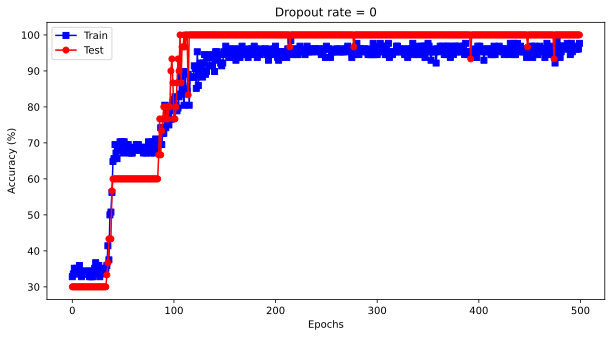

In [29]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'bs-')
plt.plot(testAcc,'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate = %g'%dropoutrate)

plt.show()

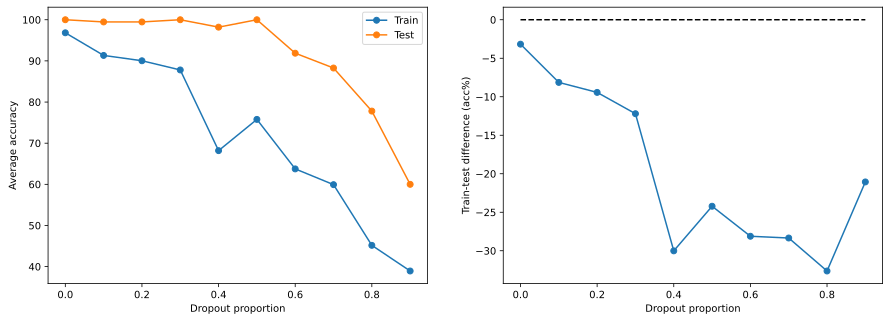

In [30]:
# run an experiment

dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):

  # create and train the model
  ANNiris,lossfun,optimizer = createANewModel(dropoutRates[di])
  trainAcc,testAcc = trainTheModel()

  # store accuracies
  results[di,0] = np.mean(trainAcc[-50:])
  results[di,1] = np.mean(testAcc[-50:])



# plot the experiment results
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

Note : The dropout is not generally good for small models and even when data is less. The architecture should be big enough and one should have sufficient data for dropouts to show benefits.

### L1/L2 Regularization : The weights regularization

1. "penalty term" is added to the the cost function itself, and this term is driven directly from the weights which are getting updated
2. L2 regularization ('ridge' or 'weight decay') shrinks the weights, especially large weights. It has diminishing returns close to 0 due to squaring effect.
3. L1 regularization ('lasso') creates sparse weights by setting some to 0.
4. Regularization parameters (lambda) should be small to keep penalty lower than the main cost term, but reasonable enough to have an impact.

Other possibilities of regularization:
1. L1+L2 ("elastic net" regression)
2. Norm of weight matrix (more later in the course)
3. Sample specific (positive bias on cancer diagnosis)

Why does it reduce overfitting?
1. Discourage complex and sample specific representations
2. Avoid large weights to cause instability (especially in deep networks)

When to use L1/L2 regularization?
1. In large, complex models with lots of weights (high risk of overfitting)
2. Use L1 when trying to understand the encoding features (more common in regression)
3. **When training accuracy is much higher than validation accuracy**

### Implementation of L2 Regularization : Iris Dataset

In [31]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# load the dataloader
from torch.utils.data import DataLoader


# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')


# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

In [32]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# create dataloader objects
train_loader = DataLoader(train_dataDataset,batch_size=64, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

In [33]:
# a function that creates the ANN model

def createANewModel(L2lambda):

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.005,weight_decay=L2lambda)
  # L2/L1 regularization is applied here, don't miss out.

  return ANNiris,lossfun,optimizer

In [34]:
# train the model

# global parameter
numepochs = 1000

def trainTheModel():

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for epochi in range(numepochs):

    # need to toggle train mode here??

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    # test accuracy
    ANNiris.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

    # no worries, reset here ;)
    ANNiris.train()

  # function output
  return trainAcc,testAcc,losses

In [37]:
# create a model
L2lambda = .01
ANNiris,lossfun,optimizer = createANewModel(L2lambda)

# train the model
trainAcc,testAcc,losses = trainTheModel()
# trainAcc,testAcc,losses

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-1941010148.py:8: SyntaxWarning: invalid escape sequence '\l'
  ax[0].set_title('Losses with L2 $\lambda$=' + str(L2lambda))
/tmp/ipython-input-1941010148.py:12: SyntaxWarning: invalid escape sequence '\l'
  ax[1].set_title('Accuracy with L2 $\lambda$=' + str(L2lambda))


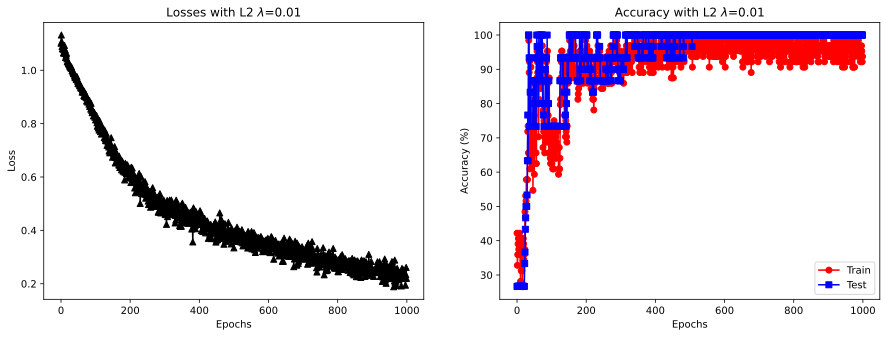

In [40]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L2 $\lambda$=' + str(L2lambda))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with L2 $\lambda$=' + str(L2lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()

In [41]:
## Run The Experiment

# range of L2 regularization amounts
l2lambdas = np.linspace(0,.1,10)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs,len(l2lambdas)))
accuracyResultsTest  = np.zeros((numepochs,len(l2lambdas)))


# loop over batch sizes
for li in range(len(l2lambdas)):

  # create and train a model
  ANNiris,lossfun,optimizer = createANewModel(l2lambdas[li])
  trainAcc,testAcc,losses = trainTheModel()

  # store data
  accuracyResultsTrain[:,li] = smooth(trainAcc,10)
  accuracyResultsTest[:,li]  = smooth(testAcc,10)

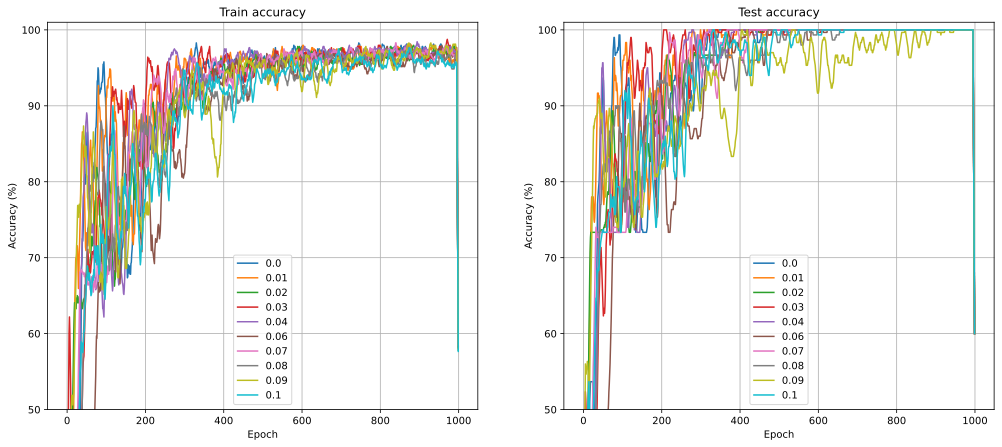

In [42]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = [np.round(i,2) for i in l2lambdas]

# common features
for i in range(2):
  ax[i].legend(leglabels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()

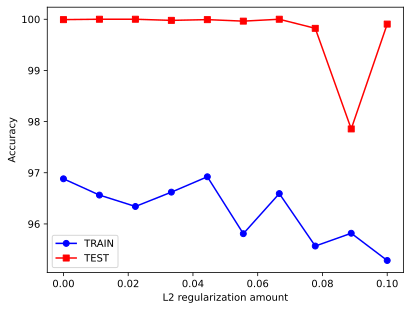

In [43]:
# show average accuracy by L2 rate

# average only some epochs
epoch_range = [500,950]


plt.plot(l2lambdas,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(l2lambdas,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L2 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()# import libraries

### Implementation of L1 Regularization : Iris Dataset

In [44]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# load the dataloader
from torch.utils.data import DataLoader


# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')


# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

In [45]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# create dataloader objects
train_loader = DataLoader(train_dataDataset,batch_size=64, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

In [49]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.005)
  # No L1 regularization is applied here, there is no such command.

  return ANNiris,lossfun,optimizer

In [52]:
# train the model

# global parameter
numepochs = 1000

def trainTheModel(L1lambda):

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # count the total number of weights in the model
  nweights = 0
  for pname,weight in ANNiris.named_parameters():
    if 'bias' not in pname:
      nweights = nweights + weight.numel()


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)



      ### add L1 term
      L1_term = torch.tensor(0.,requires_grad=True)

      # sum up all abs(weights)
      for pname,weight in ANNiris.named_parameters():
        if 'bias' not in pname:
           L1_term = L1_term + torch.sum(torch.abs(weight))

      # add to loss term
      loss = loss + L1lambda*L1_term/nweights
      # See it is applied manually here!!

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses

In [53]:
# create a model
ANNiris,lossfun,optimizer = createANewModel()

# train the model
L1lambda = .001
trainAcc,testAcc,losses = trainTheModel(L1lambda)

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-3151728833.py:8: SyntaxWarning: invalid escape sequence '\l'
  ax[0].set_title('Losses with L1 $\lambda$=' + str(L2lambda))
/tmp/ipython-input-3151728833.py:12: SyntaxWarning: invalid escape sequence '\l'
  ax[1].set_title('Accuracy with L1 $\lambda$=' + str(L2lambda))


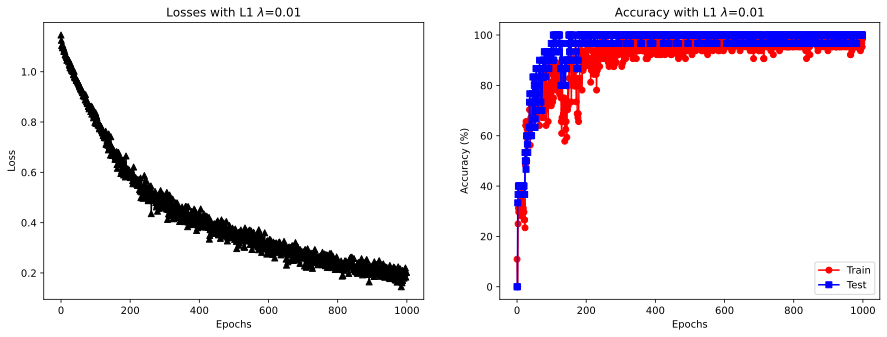

In [55]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L1 $\lambda$=' + str(L2lambda))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with L1 $\lambda$=' + str(L2lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()

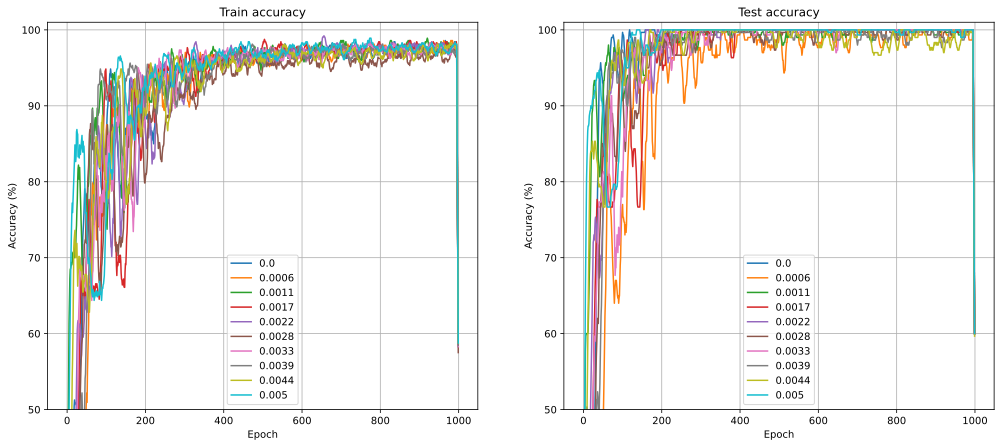

In [56]:
## Run The Experiment

# range of L1 regularization amounts
L1lambda = np.linspace(0,.005,10)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs,len(L1lambda)))
accuracyResultsTest  = np.zeros((numepochs,len(L1lambda)))


# loop over batch sizes
for li in range(len(L1lambda)):

  # create and train a model
  ANNiris,lossfun,optimizer = createANewModel()
  trainAcc,testAcc,losses = trainTheModel(L1lambda[li])

  # store data
  accuracyResultsTrain[:,li] = smooth(trainAcc,10)
  accuracyResultsTest[:,li]  = smooth(testAcc,10)


# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = [np.round(i,4) for i in L1lambda]

# common features
for i in range(2):
  ax[i].legend(leglabels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()

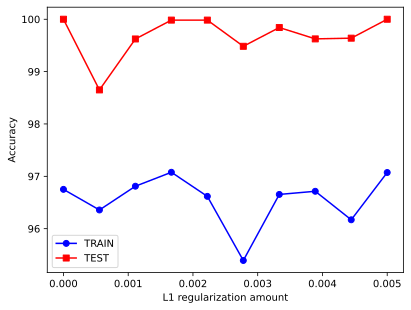

In [57]:
# show average accuracy by L1 rate

# average only some epochs
epoch_range = [400,600]


plt.plot(L1lambda,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(L1lambda,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L1 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Mini-Batch Training

1. Batch sizes are often done in power of 2 (2,4,8..) between 2 to 512
2. Low batch size decrease the computation time because of vectorization (matrix multiplication instead of for-loops)
3. But for large batch size, the computation time actually increases due to large computations of matrix multiplication
4. Batching is a form of regularization: It smooths the learning curve by averaging the loss over many samples, therby reduces overfitting.
5. But, with similar samples, it mostly show low improvement as averaging effect losses benefits.

### Effect of Mini-Batch Size

In [58]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# libraries for partitioning and batching the data
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [59]:
# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')


# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

In [60]:

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, train_size=.8)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)

# converted to dataloaders later!

In [61]:
def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
      #nn.Softmax(dim=1), # final activation unit (you probably don't need more reminders that this is just conceptual ;)  )
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.001)

  return ANNiris,lossfun,optimizer

In [62]:
# train the model

# global parameter
numepochs = 500

def trainTheModel():

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for epochi in range(numepochs):

    # activate training mode
    ANNiris.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )


    ### test accuracy

    # extract X,y from test dataloader
    X,y = next(iter(test_loader))

    # activate testing mode
    ANNiris.eval()
    with torch.no_grad():
      predlabels = torch.argmax( ANNiris(X),axis=1 )

    # compute accuracy
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses

In [63]:
### Run the Experiment

# range of batch sizes
batchsizes = 2**np.arange(1,7)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs,len(batchsizes)))
accuracyResultsTest  = np.zeros((numepochs,len(batchsizes)))

# test data doesn't vary by training batch size
test_loader = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# loop over batch sizes
for bi in range(len(batchsizes)):

  # create dataloader object
  train_loader = DataLoader(train_dataDataset,
                          batch_size=int(batchsizes[bi]), shuffle=True, drop_last=True)

  # create and train a model
  ANNiris,lossfun,optimizer = createANewModel()
  trainAcc,testAcc,losses = trainTheModel()

  # store results
  accuracyResultsTrain[:,bi] = trainAcc
  accuracyResultsTest[:,bi]  = testAcc

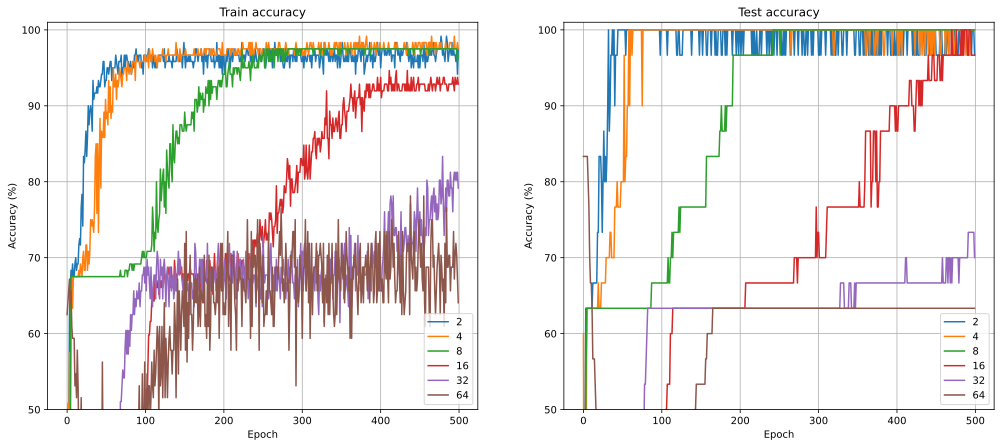

In [64]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(batchsizes)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()

**Conclusion:**

1. Here, the low batch sizes showed better results because the samples were relatively similar and smaller batch size allowed for faster convergence towards minima.
2. In cases of computer vision, where more diverse samples are present, the higher batch sizes tend to perform relatively better since bigger batches provide more information.